In [31]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
from mpl_toolkits.axes_grid1 import make_axes_locatable
from sklearn import metrics
from scipy.stats import pearsonr, norm
import time
import random
import xgboost
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score, accuracy_score, log_loss, make_scorer
from sklearn.ensemble import ExtraTreesClassifier, ExtraTreesRegressor, RandomForestClassifier
import math
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV, cross_validate, GridSearchCV
from sklearn.base import clone
from sklearn.neural_network import MLPClassifier
import pickle

## Definition of helper functions

In [10]:
def missing_values_table(df):
    mis_val = df.isnull().sum()
    mis_val_percent = 100 * df.isnull().sum() / len(df)
    mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
    mis_val_table_ren_columns = mis_val_table.rename(
    columns = {0 : 'Missing Values', 1 : '% of Total Values'})
    mis_val_table_ren_columns = mis_val_table_ren_columns[
        mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
    '% of Total Values', ascending=False).round(1)
    print ("Your selected dataframe has " + str(df.shape[1]) + " columns.\n"
        "There are " + str(mis_val_table_ren_columns.shape[0]) +
            " columns that have missing values.")
    return mis_val_table_ren_columns

## Setting Hyperparameters and reading dataset

In [11]:
dataset_path = "notebooks/dataset_creation/csv/dataset.csv"
start_year = 2010
num_years_training = 2
num_years_validation = 1
elapsed_training_time = 0
elapsed_prediction_time = 0
k_folds = 5
num_years = 5
n_seeds = 1
num_classes = 3
class_labels = [0, 1, 2]
scaling = 'minmax' # 'std' to use std scaling
to_scale = False
verbose = True
early_stopping_rounds = 2
cv = 5
np.random.seed()
seed = np.random.randint(100000)
dataset = pd.read_csv(dataset_path)
dataset['time'] = pd.to_datetime(dataset['time'])
cost_matrix = np.array([
        [0, 0.1, 1.],
        [0.1, 0, 0.1],
        [1., 0.1, 0]
])

## Exploring dataset

In [12]:
dataset.describe()

,time_to_roll,time_to_auction,spread,mid,imbalance,delta_mid_0,delta_mid_1,delta_mid_2,delta_mid_3,delta_mid_4,...,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12
count,1.746151e+06,1.746151e+06,1.746151e+06,1.746151e+06,1.746151e+06,1.679037e+06,1.637361e+06,1.614866e+06,1.611267e+06,1.608259e+06,...,1.746151e+06,1.746151e+06,1.746151e+06,1.746151e+06,1.746151e+06,1.746151e+06,1.746151e+06,1.746151e+06,1.746151e+06,1.746151e+06
mean,4.715596e+01,1.422170e+01,1.720362e-02,1.272128e+02,-1.382366e-01,2.931049e-03,4.800952e-03,4.318131e-03,3.425026e-03,4.198836e-03,...,7.708554e-02,8.438961e-02,9.172517e-02,7.546655e-02,9.398042e-02,9.503130e-02,6.965721e-02,8.719120e-02,8.614318e-02,6.158230e-02
std,2.483470e+01,9.839434e+00,1.340682e-02,1.535810e+01,6.033833e+01,2.521574e-01,2.691041e-01,2.641043e-01,2.603343e-01,2.630249e-01,...,2.667272e-01,2.779713e-01,2.886377e-01,2.641428e-01,2.918016e-01,2.932583e-01,2.545685e-01,2.821151e-01,2.805754e-01,2.403954e-01
min,4.000000e+00,0.000000e+00,1.000000e-02,8.748000e+01,-1.658000e+03,-6.772167e+00,-6.772167e+00,-6.772167e+00,-6.772167e+00,-6.772167e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,2.600000e+01,7.000000e+00,1.000000e-02,1.146950e+02,-2.500000e+01,-1.045833e-01,-1.046552e-01,-1.012500e-01,-1.015000e-01,-1.025000e-01,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,4.700000e+01,1.400000e+01,1.000000e-02,1.291950e+02,0.000000e+00,5.916667e-03,6.916667e-03,6.637931e-03,6.250000e-03,7.166667e-03,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
75%,6.900000e+01,2.100000e+01,2.000000e-02,1.392450e+02,2.500000e+01,1.133333e-01,1.163333e-01,1.119167e-01,1.107895e-01,1.137500e-01,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
max,9.100000e+01,6.200000e+01,5.100000e-01,1.557050e+02,3.068000e+03,1.047412e+01,1.200000e+01,1.200000e+01,1.200000e+01,1.200000e+01,...,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00


In [13]:
print(missing_values_table(dataset))

Your selected dataframe has 45 columns.
There are 20 columns that have missing values.
              Missing Values  % of Total Values
delta_mid_18          212069               12.1
delta_mid_19          210032               12.0
delta_mid_17          204721               11.7
delta_mid_16          195855               11.2
delta_mid_15          188896               10.8
delta_mid_14          187255               10.7
delta_mid_13          184914               10.6
delta_mid_7           165172                9.5
delta_mid_8           163982                9.4
delta_mid_12          161584                9.3
delta_mid_6           156672                9.0
delta_mid_5           146483                8.4
delta_mid_4           137892                7.9
delta_mid_3           134884                7.7
delta_mid_2           131285                7.5
delta_mid_11          129179                7.4
delta_mid_9           128319                7.3
delta_mid_1           108790                6.2
d

In [22]:

def make_xgb_plain(seed):
    model = XGBClassifier(random_state=seed)
    return model

def make_xgb_regularized1(seed, max_depth=5, n_estimators=100, subsample=0.2, colsample_bytree=0.5, **kwargs):
    model = XGBClassifier(random_state=seed, max_depth=max_depth, n_estimators=n_estimators, subsample=subsample,
                         early_stopping_rounds=early_stopping_rounds, colsample_bytree=colsample_bytree, **kwargs)
    return model

def make_xgb_regularized2(seed, max_depth=5, n_estimators=100, subsample=0.2, colsample_bytree=0.2, **kwargs):
    model = XGBClassifier(random_state=seed, max_depth=max_depth, n_estimators=n_estimators, subsample=subsample,
                         early_stopping_rounds=early_stopping_rounds, colsample_bytree=colsample_bytree, **kwargs)
    return model
def make_xgb_regularized3(seed, max_depth=5, n_estimators=100, subsample=0.1, colsample_bytree=0.2, **kwargs):
    model = XGBClassifier(random_state=seed, max_depth=max_depth, n_estimators=n_estimators, subsample=subsample,
                         early_stopping_rounds=early_stopping_rounds, colsample_bytree=colsample_bytree, **kwargs)
    return model

def make_xgb_regularized4(seed, max_depth=3, n_estimators=200, subsample=0.1, colsample_bytree=0.2, **kwargs):
    model = XGBClassifier(random_state=seed, max_depth=max_depth, n_estimators=n_estimators, subsample=subsample,
                         early_stopping_rounds=early_stopping_rounds, colsample_bytree=colsample_bytree, **kwargs)
    return model

def make_xgb_regularized5(seed, max_depth=3, n_estimators=100, subsample=0.1, colsample_bytree=0.2, **kwargs):
    model = XGBClassifier(random_state=seed, max_depth=max_depth, n_estimators=n_estimators, subsample=subsample,
                         early_stopping_rounds=early_stopping_rounds, colsample_bytree=colsample_bytree, **kwargs)
    return model

def make_xgb_regularized6(seed, max_depth=5, n_estimators=30, subsample=0.1, colsample_bytree=0.2, **kwargs):
    model = XGBClassifier(random_state=seed, max_depth=max_depth, n_estimators=n_estimators, subsample=subsample,
                         early_stopping_rounds=early_stopping_rounds, colsample_bytree=colsample_bytree, **kwargs)
    return model
    
def make_mlp_plain(seed, **kwargs):
    model = MLPClassifier(random_state=seed, learning_rate="adaptive", batch_size=256, hidden_layer_sizes=[100,100],
                        activation='relu', alpha=0.0001, solver='adam', **kwargs)
    return model

def make_mlp_regularized(seed, **kwargs):
    model = MLPClassifier(random_state=seed, learning_rate="adaptive", batch_size=256, hidden_layer_sizes=[100,100],
                        activation='relu', alpha=0.05, solver='adam', **kwargs)
    return model

model_producers = [make_xgb_regularized6] #, make_xgb_regularized2, make_xgb_regularized3, make_xgb_regularized4, make_xgb_regularized5  ] # make_mlp_regularized, make_mlp_plain, make_xgb_plain,
model_labels = ["xgb_regularized6"] # "xgb_regularized2", "xgb_regularized3", "xgb_regularized4", "xgb_regularized5"] # "mlp_regularized", "mlp_plain", "xgb_plain",

all_features = list(dataset.columns)
all_features.remove("delta_mid_target")
all_features.remove("time")
no_history_features = []
for feature in all_features:
    if feature == "delta_mid_0" or "delta_mid" not in feature:
        no_history_features.append(feature)
no_history_no_mid_features = no_history_features.copy()
no_history_no_mid_features.remove("mid")
no_mid_features = all_features.copy()
no_mid_features.remove("mid")

feature_sets = [all_features, no_mid_features, no_history_features, no_history_no_mid_features]
feature_set_labels = ["no_mid", "no_mid_no_history"] #"all", "no_history", 

num_training_years_array = [2, 3, 4, 5, 6] #2, 3, 4, 
num_models = len(model_producers)
num_feature_sets = len(feature_sets)
num_interval_years = len(num_training_years_array)

## Initializing data structures

In [15]:
# Execute this cell every time to reset results
scores = np.zeros((num_feature_sets, num_models, num_interval_years, num_years, k_folds))
scores_train = np.zeros((num_feature_sets, num_models, num_interval_years, num_years, k_folds))

## Define custom loss function

In [45]:
weights = cost_matrix
def weighted_classification_loss(y_pred, y):
    # y = dtrain.get_label()
    # y_pred = predt
    # Create an indicator - 0 if correct, 1 otherwise
    errors = pd.DataFrame((~(y == y_pred)).astype(int).rename('Result'))
    # Use the product totals dataset to create results
    results = errors.merge(weights, left_index=True, right_index=True, how='inner')
    # Calculate per-prediction loss
    loss = results.Result * results.SumNetAmount
    return loss.mean()

custom_scorer = make_scorer(weighted_classification_loss, greater_is_better=False)

In [ ]:
def softmax(x):
    e_x = np.exp(x - np.max(x, axis=1, keepdims=True))
    return e_x / e_x.sum(axis=1, keepdims=True)
 
class CustomObjective:
    def __init__(self, cost_matrix):
        self.cost_matrix = cost_matrix
 
    def __call__(self, y_true, y_pred):
        labels = y_true.astype(int)
        weights = self.cost_matrix
        p = softmax(y_pred)
        rows = np.arange(y_pred.shape[0])
        g = p.copy()
        g[rows, labels] -= 1.0
        g *= weights[labels, np.argmax(p, axis=1)].reshape(-1, 1)
        h = p * (1.0 - p) * weights[labels, np.argmax(p, axis=1)].reshape(-1, 1)
        h = np.maximum(h, 1e-6)
        grad = g.flatten()
        hess = h.flatten()
        return grad, hess
custom_xgb_objective = CustomObjective(cost_matrix)    

In [48]:
# def softmax(x):
#     '''Softmax function with x as input vector.'''
#     e_x = np.exp(x - np.max(x))
#     return e_x / e_x.sum()
    
# class CustomObjective:
#     def __init__(self, cost_matrix):
#         self.cost_matrix = cost_matrix

#     def __call__(self, y_true, y_pred):
#         '''Loss function.  Computing the gradient and approximated hessian (diagonal).
#             Reimplements the `multi:softprob` inside XGBoost.
#             '''
#         labels = y_true
#         weights = self.cost_matrix
#         grad = np.zeros_like(y_pred)
#         hess = np.zeros_like(y_pred)

#         eps = 1e-6

#         # compute the gradient and hessian, slow iterations in Python, only
#         # suitable for demo.  Also the one in native XGBoost core is more robust to
#         # numeric overflow as we don't do anything to mitigate the `exp` in
#         # `softmax` here.
#         for r in range(y_pred.shape[0]):
#             target = int(labels[r])
#             p = softmax(y_pred[r, :])
#             pred_target = np.argmax(p)
#             for c in range(y_pred.shape[1]):
#                 w = weights[target, pred_target]
#                 g = p[c] - 1.0 if c == target else p[c]
#                 g = g * w
#                 h = max((2.0 * p[c] * (1.0 - p[c]) * w).item(), eps)
#                 grad[r, c] = g
#                 hess[r, c] = h
#         kRows = y_pred.shape[0]
#         kClasses = y_pred.shape[1]
#         grad = grad.reshape((kRows * kClasses, 1))
#         hess = hess.reshape((kRows * kClasses, 1))
#         return grad, hess
# custom_xgb_objective = CustomObjective(cost_matrix)

In [51]:
for feature_index, feature_set in enumerate(feature_sets):        
    feature_set_label = feature_set_labels[feature_index]
    print(f'Fitting models with {feature_set_label} features!')
    for model_index, model_producer in enumerate(model_producers):
        model_label = model_labels[model_index]
        # if "xgb" in model_label:
        #     continue #temporary
        print(f'Fitting {model_label} models!')
        for num_year_training_index, num_years_training in enumerate(num_training_years_array):
            for year in range(num_years):
                    training_years = [start_year + year + k for k in range(num_years_training)]
                    validation_years = [start_year + num_years_training + year + k for k in range(num_years_validation)]
                    label = f'tr_{training_years[0]}-{training_years[-1]}_tst_{validation_years[0]}-{validation_years[-1]}'
                    df_train = dataset[dataset.time.dt.year.isin(training_years)]
                    df_validation = dataset[dataset.time.dt.year.isin(validation_years)]
                    # deal with NANs
                    if "xgb" not in model_label:
                        df_train = df_train.ffill().bfill()
                        df_validation = df_validation.ffill().bfill()
                    df_train = df_train.drop(columns = "time")
                    df_validation = df_validation.drop(columns = "time")
                    print(f'starting years {training_years[0]}-{training_years[-1]}')
                    for fold in range(0, k_folds):
                        np.random.seed()
                        seed = np.random.randint(100000)
                        model = model_producer(seed, objective=custom_xgb_objective)
                        if verbose:
                            print('Started execution of fold ' +      str(fold+1) + '/' +  str(k_folds) + ' with random seed ' + str(seed) + '.', end='\r')
                        
                        train = df_train.sample(frac=0.8, random_state=seed).reset_index(drop=True)
                        validation = df_validation.sample(frac=0.8, random_state=seed).reset_index(drop=True)
                        X_train = train.drop(columns="delta_mid_target")[feature_set]
                        y_train = train["delta_mid_target"]
                        X_val = validation.drop(columns = "delta_mid_target")[feature_set]
                        y_val = validation["delta_mid_target"]
                        
                        X_variables = X_train.columns

                        y_train, b = pd.qcut(y_train, num_classes, retbins=True, labels=class_labels)
                        b[0], b[-1] = -np.inf, np.inf
                        # and use the same cutpoints to label the validation set.
                        y_val = pd.cut(y_val, bins=b, labels=class_labels)
                        
                        # y_train = y_train.values.reshape(-1, 1)
                        # y_val = y_val.values.reshape(-1, 1)
                        
                    
                        if to_scale:
                            if scaling == 'std':
                                std_scaler_x = StandardScaler()
                                std_scaler_x.fit(X_train)
                                X_train = std_scaler_x.transform(X_train)
                                X_val = std_scaler_x.transform(X_val)
                            elif scaling == 'minmax':
                                minmaxscaler_x = MinMaxScaler()
                                minmaxscaler_x.fit(X_train)
                                X_train = minmaxscaler_x.transform(X_train)
                                X_val = minmaxscaler_x.transform(X_val)
                    
                        t = time.time()
                        model.fit(X_train, y_train, eval_set=[(X_val, y_val)])
                        elapsed_training_time += time.time() - t
                
                        t = time.time()
                        y_pred = model.predict(X_val)
                        y_pred_train = model.predict(X_train)
                        elapsed_prediction_time += time.time()-t
                        
                        scores[feature_index, model_index, num_year_training_index, year, fold] = custom_scorer(y_val, y_pred)
                        scores_train[feature_index, model_index, num_year_training_index, year, fold] = custom_scorer(y_train, y_pred_train)
                        
            print(f'Finished cross-validation: {training_years[0]}-{training_years[-1]}')

Fitting models with no_mid features!
Fitting xgb_regularized6 models!
starting years 2010-2011
[0]	validation_0-mlogloss:1.09715h random seed 25840.
[1]	validation_0-mlogloss:1.05552
[2]	validation_0-mlogloss:1.05982
[3]	validation_0-mlogloss:1.05355
[4]	validation_0-mlogloss:1.05690


TypeError: __call__() missing 1 required positional argument: 'y_true'

In [ ]:
results = {
    "train": {
        "score": scores_train,
    },
    "test": {
        "score": scores,
    }
}

with open('results_classification.pkl', 'wb') as outp:
    pickle.dump(results, outp, pickle.HIGHEST_PROTOCOL)


In [37]:
print(model.get_num_boosting_rounds())

30


In [ ]:
print("TRAIN METRICS")
for feature_index, feature_set in enumerate(feature_set_labels):
    for model_index, model_label in enumerate(model_labels):
        for num_training_year_index, interval_length in enumerate(num_training_years_array):
            print(f'Metrix for {feature_set} - {model_label} - {interval_length} years of training')
            print('MAPE:\t\t\t\t\t\tAverage = {:.3f}\t\tStandard deviation = {:.3f}'.format(np.mean(MAPEs_train[feature_index, model_index, num_training_year_index]), np.std(MAPEs_train[feature_index, model_index, num_training_year_index])))
            print('MSE:\t\t\t\t\t\tAverage = {:.3f}\t\tStandard deviation = {:.3f}'.format(np.mean(MSEs_train[feature_index, model_index, num_training_year_index]), np.std(MSEs_train[feature_index, model_index, num_training_year_index])))
            print('R2:\t\t\t\t\t\tAverage = {:.3f}\t\tStandard deviation = {:.3f}'.format(np.mean(R2s_train[feature_index, model_index, num_training_year_index]), np.std(R2s_train[feature_index, model_index, num_training_year_index])))
            print('Adjusted R2:\t\t\t\t\tAverage = {:.3f}\t\tStandard deviation = {:.3f}'.format(np.mean(AdjR2s_train[feature_index, model_index, num_training_year_index]), np.std(AdjR2s_train[feature_index, model_index, num_training_year_index])))


In [ ]:
id_worst = np.argmin(R2s)
id_best = np.argmax(R2s)
print("CROSS-VALIDATION METRICS")

for feature_index, feature_set in enumerate(feature_set_labels):
    for model_index, model_label in enumerate(model_labels):
        for num_training_year_index, interval_length in enumerate(num_training_years_array):
            print(f'Metrix for {feature_set} - {model_label} - {interval_length} years of training')
            print('MAPE:\t\t\t\t\t\tAverage = {:.3f}\t\tStandard deviation = {:.3f}'.format(np.mean(MAPEs[feature_index, model_index, num_training_year_index]), np.std(MAPEs[feature_index, model_index, num_training_year_index])))
            print('MSE:\t\t\t\t\t\tAverage = {:.3f}\t\tStandard deviation = {:.3f}'.format(np.mean(MSEs[feature_index, model_index, num_training_year_index]), np.std(MSEs[feature_index, model_index, num_training_year_index])))
            print('R2:\t\t\t\t\t\tAverage = {:.3f}\t\tStandard deviation = {:.3f}'.format(np.mean(R2s[feature_index, model_index, num_training_year_index]), np.std(R2s[feature_index, model_index, num_training_year_index])))
            print('Adjusted R2:\t\t\t\t\tAverage = {:.3f}\t\tStandard deviation = {:.3f}'.format(np.mean(AdjR2s[feature_index, model_index, num_training_year_index]), np.std(AdjR2s[feature_index, model_index, num_training_year_index])))

## Visualizing results

In [7]:
with open('results_new.pkl', 'rb') as inp:
    results = pickle.load(inp)
print(results["test"]["r2"].shape)

(4, 5, 5, 5, 5)


In [15]:
results["test"].keys()

dict_keys(['mape', 'mse', 'r2', 'ar2'])

In [25]:
def visualize_results(data, kpi_label):
    width =  1 / data.shape[1] - 0.05  # the width of the bars
    for feature_index, feature_set in enumerate(feature_set_labels):
        means = data[feature_index].mean(axis=(-1, -2))
        stds = data[feature_index].std(axis=(-1, -2))
        ind = np.arange(means.shape[0]) # the x locations for the groups    
        fig, ax = plt.subplots()
        rects = []
        for i in range(means.shape[1]):
            label = f'{num_training_years_array[i]} years'
            rec = ax.bar(ind - (2-i) * width, means[:,i], width, yerr=stds[:, i], label=label)
            rects.append(rec)
        
        # Add some text for labels, title and custom x-axis tick labels, etc.
        ax.set_ylabel(kpi_label)
        ax.set_title(feature_set)
        ax.set_xticks(ind)
        ax.set_xticklabels([f'xgb-{i}' for i in range(means.shape[0])])
        ax.legend()
        fig.tight_layout()
        
        plt.show()


In [ ]:
# max_depth=5, n_estimators=100, subsample=0.2, colsample_bytree=0.5
# max_depth=5, n_estimators=100, subsample=0.2, colsample_bytree=0.2
# max_depth=5, n_estimators=100, subsample=0.1, colsample_bytree=0.2
# max_depth=3, n_estimators=200, subsample=0.1, colsample_bytree=0.2
# max_depth=3, n_estimators=100, subsample=0.1, colsample_bytree=0.2

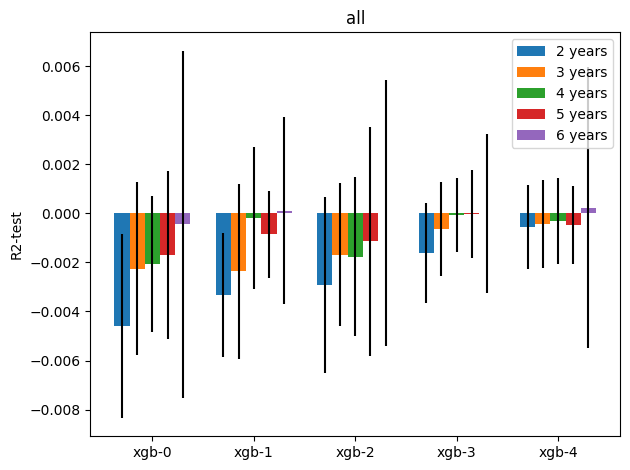

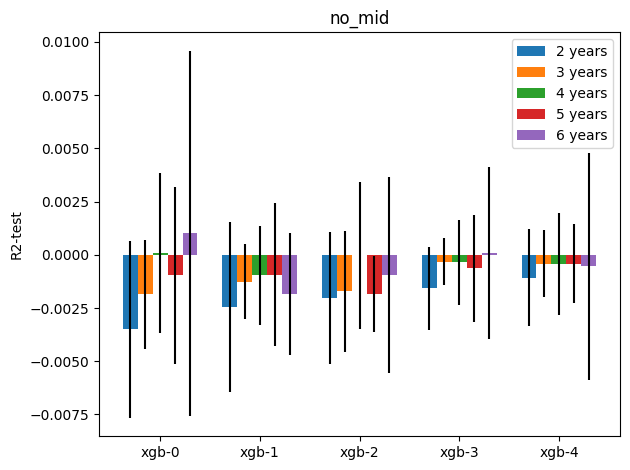

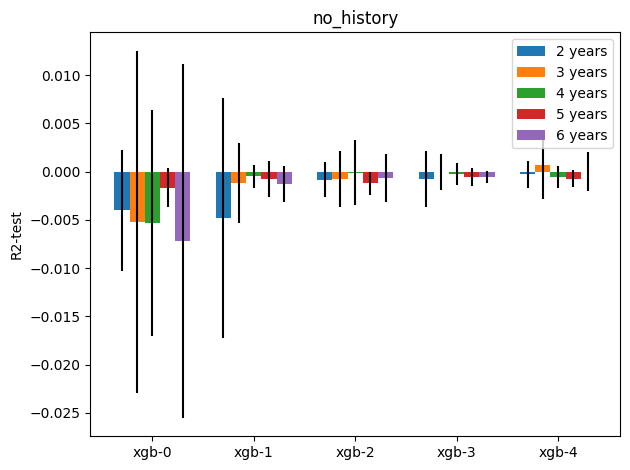

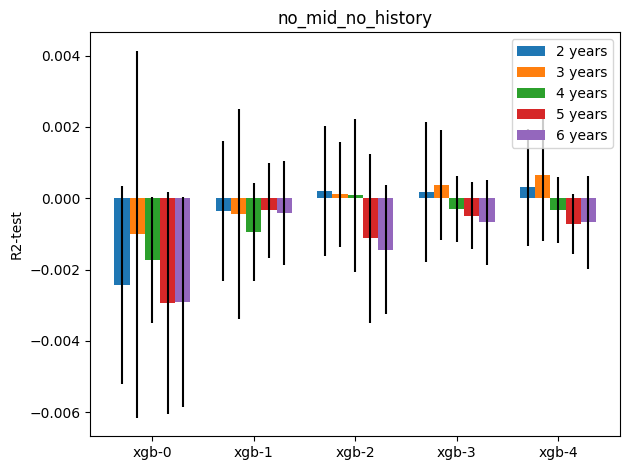

In [29]:
visualize_results(results["test"]["r2"], "R2-test")

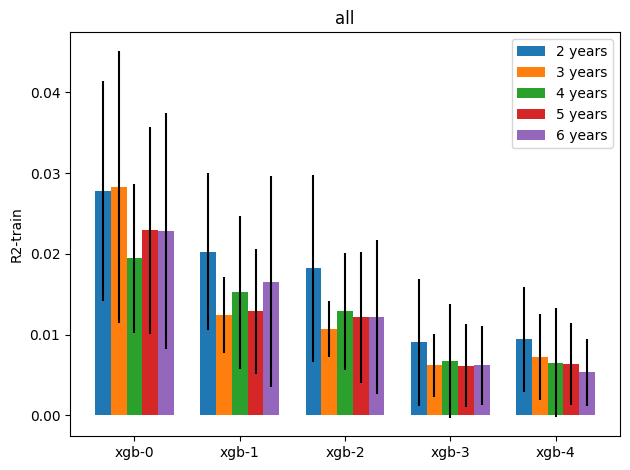

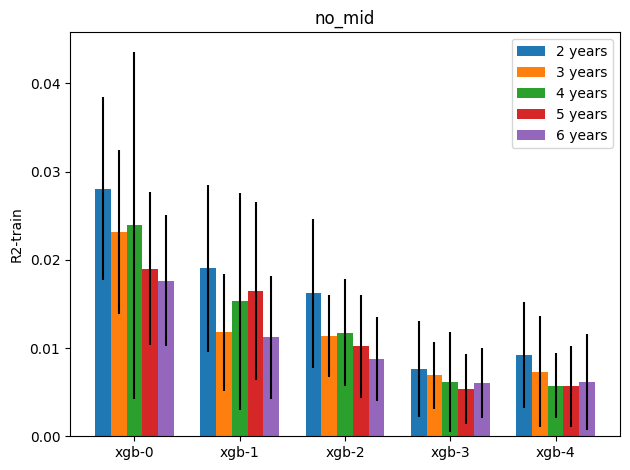

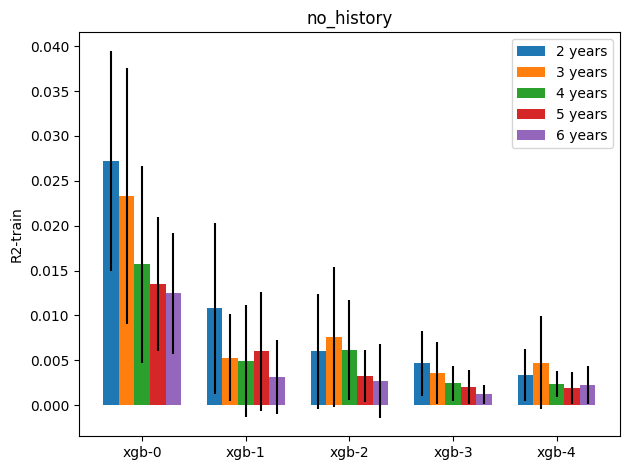

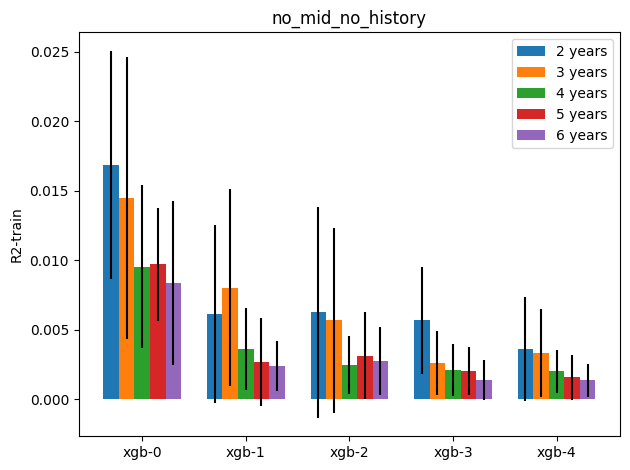

In [35]:
visualize_results(results["train"]["r2"], "R2-train")

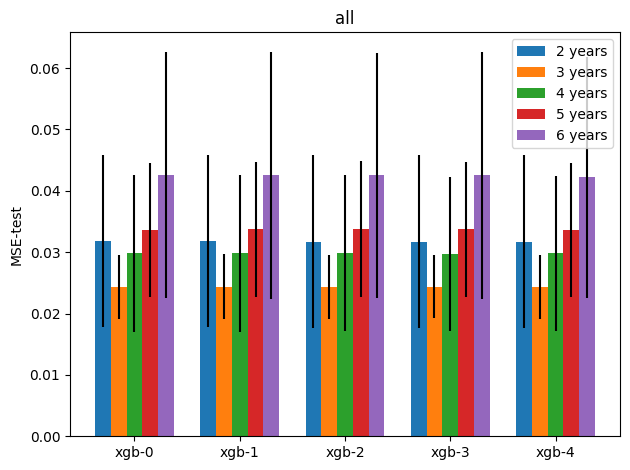

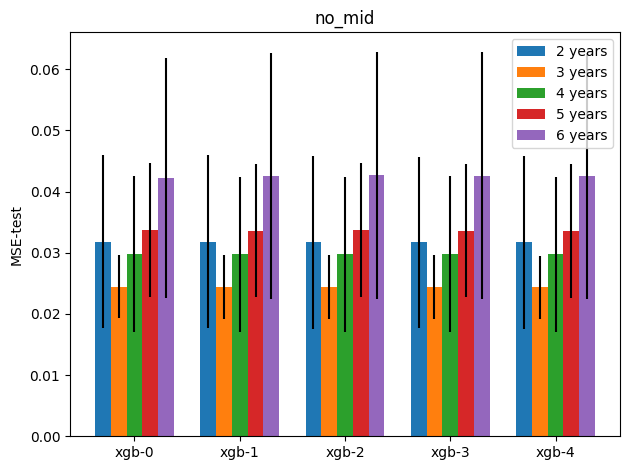

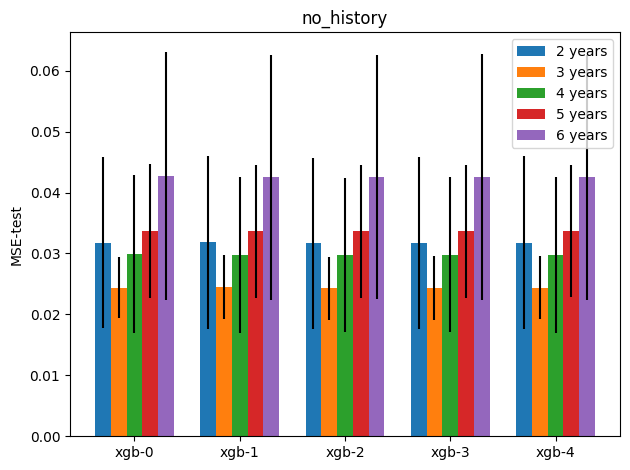

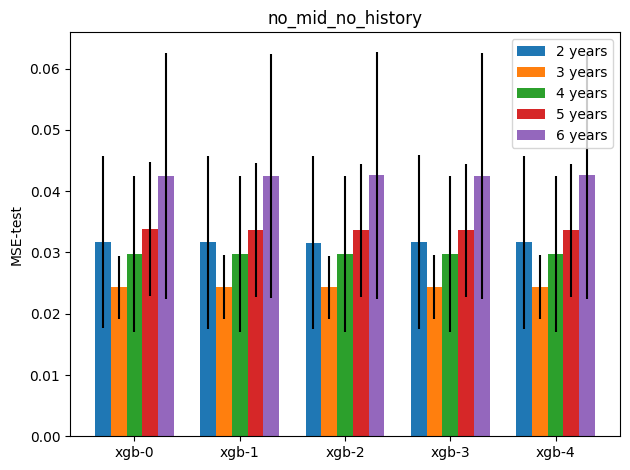

In [31]:
visualize_results(results["test"]["mse"], "MSE-test")

## Extra Code

In [ ]:
num_tests = 1 # for debug only
for i in range(num_tests):
        training_years = [start_year + i + k for k in range(num_years_training)]
        validation_years = [start_year + num_years_training + i + k for k in range(num_years_validation)]
        label = f'tr_{training_years[0]}-{training_years[-1]}_tst_{validation_years[0]}-{validation_years[-1]}'
        train = dataset[dataset.time.dt.year.isin(training_years)]
        validation = dataset[dataset.time.dt.year.isin(validation_years)]
        train = train.drop(columns = "time")
        validation = validation.drop(columns = "time")

        X_train = train.drop(columns="delta_mid_target")
        y_train = train["delta_mid_target"]
        X_val = validation.drop(columns = "delta_mid_target")
        y_val = validation["delta_mid_target"]
        from xgboost import plot_importance
        model_FI = XGBRegressor(random_state=seed)
        model_FI.fit(X_train, y_train)
